## Business Problem:
<p>to predict the value of question in game called "jeopardy"</p>

## ML Problem 
<p> have solved it as a classification model since "Value has finite set of numbers" </p>


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!ls "drive/MyDrive/Colab Notebooks/wysa"


'Copy of Copy of Untitled'   tfidf_ques_vectors_test_before_2000.pickle
'Copy of Untitled'	     tfidf_ques_vectors_train_before_2000.pickle
 final2.csv		     Untitled
 final.csv		     vectorized_cat_test_before_2000.pickle
 JEOPARDY_CSV.csv	     vectorized_cat_train_before_2000.pickle
 temp1.csv		     vectorized_locs.pickle
 temp2.csv		     w2v_model.pickle


In [3]:
#import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/wysa/JEOPARDY_CSV.csv')

In [ ]:
df

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams
...,...,...,...,...,...,...,...
216925,4999,2006-05-11,Double Jeopardy!,RIDDLE ME THIS,$2000,This Puccini opera turns on the solution to 3 ...,Turandot
216926,4999,2006-05-11,Double Jeopardy!,"""T"" BIRDS",$2000,In North America this term is properly applied...,a titmouse
216927,4999,2006-05-11,Double Jeopardy!,AUTHORS IN THEIR YOUTH,$2000,"In Penny Lane, where this ""Hellraiser"" grew up...",Clive Barker
216928,4999,2006-05-11,Double Jeopardy!,QUOTATIONS,$2000,"From Ft. Sill, Okla. he made the plea, Arizona...",Geronimo


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216930 entries, 0 to 216929
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Show Number  216930 non-null  int64 
 1    Air Date    216930 non-null  object
 2    Round       216930 non-null  object
 3    Category    216930 non-null  object
 4    Value       216930 non-null  object
 5    Question    216930 non-null  object
 6    Answer      216928 non-null  object
dtypes: int64(1), object(6)
memory usage: 11.6+ MB


In [ ]:
#there are space in beginning of column names which is not proper lets rename them
df.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [ ]:
#renamed the columns
df= df.rename({' Air Date': 'Air Date', ' Round': 'Round',' Category':'Category',' Value': 'Value',' Question': 'Question',' Answer':'Answer'}, axis=1)

In [ ]:
df.loc[df['Value'] == 'None']["Round"].value_counts()
#since for all Tiebreaker and Final Jeopardy! round the Value is None hence its not necessary to put in model to predict as its trivial hence lets split the data and remove rows with Value=None and apply ML or DL model on Values which are not None

Final Jeopardy!    3631
Tiebreaker            3
Name: Round, dtype: int64

In [ ]:
df

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams
...,...,...,...,...,...,...,...
216925,4999,2006-05-11,Double Jeopardy!,RIDDLE ME THIS,$2000,This Puccini opera turns on the solution to 3 ...,Turandot
216926,4999,2006-05-11,Double Jeopardy!,"""T"" BIRDS",$2000,In North America this term is properly applied...,a titmouse
216927,4999,2006-05-11,Double Jeopardy!,AUTHORS IN THEIR YOUTH,$2000,"In Penny Lane, where this ""Hellraiser"" grew up...",Clive Barker
216928,4999,2006-05-11,Double Jeopardy!,QUOTATIONS,$2000,"From Ft. Sill, Okla. he made the plea, Arizona...",Geronimo


In [ ]:
df = df[df['Value'] != 'None']

In [ ]:
#convert Air date from object to datetime type so we can use for feature engineering
df["Air Date"]= pd.to_datetime(df["Air Date"])

In [ ]:
#extract year
df['year'] = df['Air Date'].dt.year


# Exploratory data analysis

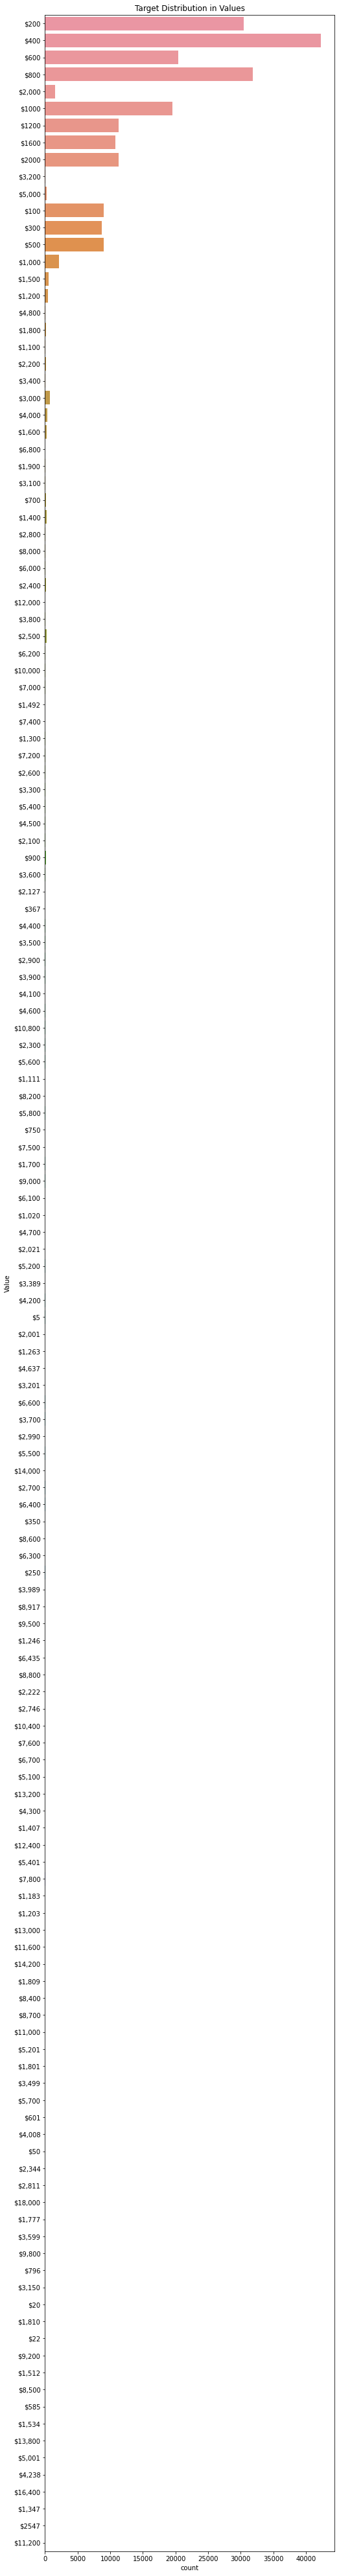

In [ ]:
plt.figure(figsize=(8, 72))
sns.countplot(y=df['Value'])

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title('Target Distribution in Values')

plt.show()

#there are many class labels which are less than 1% hence we can club them to create single class 

In [ ]:
#to club lets convert lets do some preprocessing and convert it into integer
df['Value'] = df['Value'].str.replace('$','')
df['Value'] = df['Value'].str.replace(',','')
df["Value"] = df["Value"].astype(int)

In [ ]:
#the stragey to bin/club are: if the value is smaller than 1000, then we round to the nearest hundred. 
#Otherwise, if it's between 1000 and 10k, we round it to nearest thousand. If it's greater than 10k, then we round it to the nearest 10-thousand.

def create_bins(value):
    if value < 1000:
        return np.round(value, -2)
    elif value < 10000:
        return np.round(value, -3)
    else:
        return np.round(value, -4)

df['ValueBins'] = df['Value'].apply(create_bins)

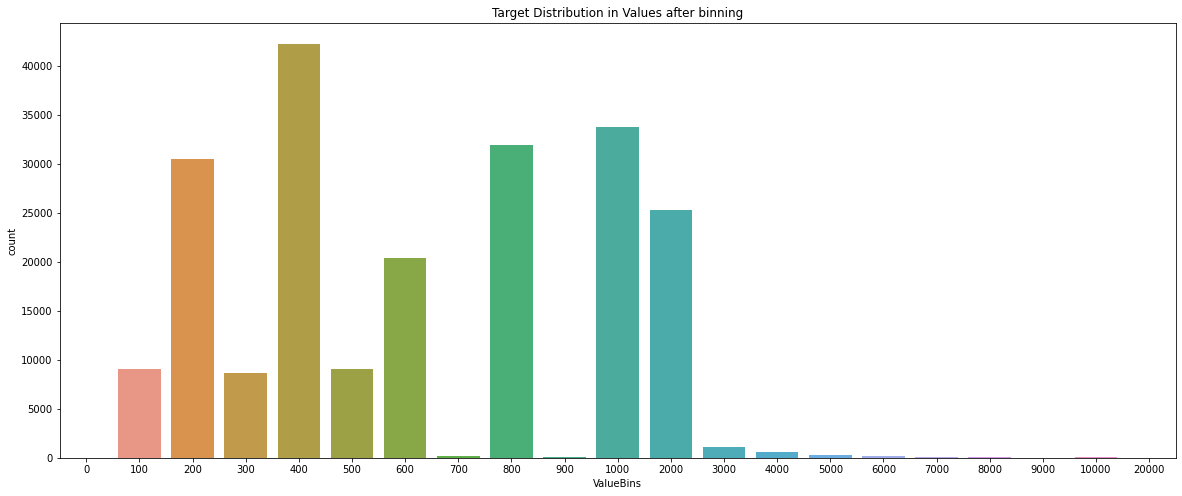

In [ ]:
plt.figure(figsize=(20, 8))
sns.countplot(x=df['ValueBins'])

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title('Target Distribution in Values after binning')

plt.show()


In [ ]:
df.drop(['Show Number','Value','Air Date','Answer'],axis=1,inplace=True)

## Processing Categroy 

In [ ]:
def decontracted(phrase):
  

    # specific
    phrase = re.sub(r"WANNA", "WANT", phrase)
    phrase = re.sub(r"U.S.", "AMERICA ", phrase)
    phrase = re.sub(r"USA", "AMERICA", phrase)
    phrase = re.sub(r"U.S.A", "AMERICA", phrase)
    
    
    return phrase

In [ ]:
from tqdm import tqdm
preprocessed_category = []
# tqdm is for printing the status bar
for sentance in tqdm(df['Category'].values):
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip() #remove words with numbers
    sentance = re.sub('<.*?>','',sentance)
    #urls
    sentance = re.sub('http[s]?://\S+|www\.\S+','',sentance)
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e for e in sentance.split() if e.lower() not in stopwords.words('english'))
    preprocessed_category.append(sentance.strip())

100%|██████████| 213296/213296 [01:07<00:00, 3168.66it/s]


In [ ]:
df["processed_Category"]=preprocessed_category #assign it to dataframe

In [ ]:
df["processed_Category"].value_counts() 
#during prepocess some categories have turned into null as they might have just contain some numbers

                        4120
WORDS                   1617
SCIENCE                  598
LITERATURE               511
MOVIES                   487
                        ... 
STREISAND FILMS            1
FLYOVER COUNTRY            1
SANE SCIENTISTS            1
DESPERADO HOUSEWIVES       1
ONE LEAF LIVE              1
Name: processed_Category, Length: 23447, dtype: int64

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/wysa/temp1.csv', 'w') as f:
  df.to_csv(f,encoding='utf-8', index=False)

In [ ]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/wysa/temp1.csv')

In [ ]:
df["processed_Category"]=df["processed_Category"].fillna('OTHERS') #fill those with label "others"

## processing question

In [ ]:
from tqdm import tqdm
preprocessed_question = []
# tqdm is for printing the status bar
for sentance in tqdm(df['Question'].values):
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('<.*?>','',sentance)
    #urls
    sentance = re.sub('http[s]?://\S+|www\.\S+','',sentance)
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e for e in sentance.split() if e.lower() not in stopwords.words('english'))
    preprocessed_question.append(sentance.strip())

100%|██████████| 213296/213296 [05:44<00:00, 619.93it/s]


In [ ]:
df["processed_question"]=preprocessed_question

In [ ]:
df.drop(["Category","Question"],axis=1,inplace=True)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/wysa/temp2.csv', 'w') as f:
  df.to_csv(f,encoding='utf-8', index=False)

In [ ]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/wysa/temp2.csv')

In [ ]:
df

,Round,year,ValueBins,processed_Category,processed_question
0,Jeopardy!,2004,200,HISTORY,last years life Galileo house arrest espousing...
1,Jeopardy!,2004,200,ESPN TOP TIME ATHLETES,Olympian football star Carlisle Indian School ...
2,Jeopardy!,2004,200,EVERYBODY TALKS,city Yuma state record average hours sunshine ...
3,Jeopardy!,2004,200,COMPANY LINE,live Art Linkletter Show company served billio...
4,Jeopardy!,2004,200,EPITAPHS TRIBUTES,Signer Dec Indep framer Constitution Mass seco...
...,...,...,...,...,...
213291,Double Jeopardy!,2006,2000,BROADWAY,cast long running hit embarked clean New York ...
213292,Double Jeopardy!,2006,2000,RIDDLE,Puccini opera turns solution riddles posed her...
213293,Double Jeopardy!,2006,2000,BIRDS,North America term properly applied species cr...
213294,Double Jeopardy!,2006,2000,AUTHORS YOUTH,Penny Lane Hellraiser grew barber shaves anoth...


# labeling Round

In [ ]:
df.loc[df["Round"]=='Jeopardy!',"Round"]=0
df.loc[df["Round"]=='Double Jeopardy!',"Round"]=1
df["Round"]=df["Round"].astype(int)
#encoding "round to integer 0 and 1 as they are ordinal variables since jeopary have less "Value"/Score compared to  "Double jeopardy",

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/wysa/final.csv', 'w') as f:
  df.to_csv(f,encoding='utf-8', index=False)

In [ ]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/wysa/final.csv')

In [ ]:
df.head(5)

,Round,year,ValueBins,processed_Category,processed_question
0,0,2004,200,HISTORY,last years life Galileo house arrest espousing...
1,0,2004,200,ESPN TOP TIME ATHLETES,Olympian football star Carlisle Indian School ...
2,0,2004,200,EVERYBODY TALKS,city Yuma state record average hours sunshine ...
3,0,2004,200,COMPANY LINE,live Art Linkletter Show company served billio...
4,0,2004,200,EPITAPHS TRIBUTES,Signer Dec Indep framer Constitution Mass seco...


In [ ]:
df.dropna(axis=0,inplace=True)

#clubbing/binning category variables

## observation/solution
<p>1)i have tried to vectorize the category just like question but with average word2vec approach  the dimensionality increased drastically as using "google' 300 dim vector for both category and question will give 600 dim in total hence model performed poorly</p>
<p>2) to reduce dimensionality i tried to club the category which are similar using cosine sim after finding "average word to vec" for each category and then found similarity for each category and clubbed them hence reducing unique categories from 23k to 6k</p>
<p> although 6k is still big so instead of one hot encoding used "target mean encoding based on "year","round","category"</p>
<p>this approach performed little better than previous approach</p>

### finding similarity of categories and clubbing them

In [ ]:
import gensim.downloader as api
w2v_model = api.load('word2vec-google-news-300')

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/wysa/w2v_model.pickle', 'wb') as f:
    pickle.dump(w2v_model, f)
    
w2v_model=pd.read_pickle(r'/content/drive/MyDrive/Colab Notebooks/wysa/w2v_model.pickle')

In [ ]:
w2v_words = list(w2v_model.wv.vocab)

In [ ]:
#finding vectors using avg w2v since sentences are not that long hence use pretrained "google-300-dim" instead of custom vocabulary to get better results
vector={}
for i in df["processed_Category"].value_counts().index:
  if i !='':
    sum_vector=np.zeros(300)
    cnt_words =0
    for j in i.split():
      if j in w2v_words:
        sum_vector=sum_vector+w2v_model.wv[j]
        cnt_words +=1
    if cnt_words != 0:
      sum_vector /=cnt_words
    vector[i]=sum_vector


In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/wysa/vectorized_locs.pickle', 'wb') as f:
  pickle.dump(vector, f)
vector=pd.read_pickle(r'/content/drive/MyDrive/Colab Notebooks/wysa/vectorized_locs.pickle')

In [ ]:
category=list(df["processed_Category"].value_counts().index)
Category_merged={}
for i in range(1,len(category)):
  if i+1<len(category):
    for j in range(i+1,len(category)):
      if category[i][-1].isnumeric() is not True and category[j][-1].isnumeric() is not True:
        if cosine_similarity([vector[category[i]]],[vector[category[j]]])>0.75:               #if two categories are atleast 75% then club the words 
          df.loc[df['processed_Category']==category[j], 'processed_Category'] = category[i].  #update/club the category
          if category[i] not in Category_merged.keys():
            Category_merged[category[i]]=[category[j]]
          else:
            Category_merged[category[i]].append(category[j])
          category[j]=category[j]+'1'

In [ ]:
Category_merged
#as can be seen that there are many words which are similar ...take 1st ex: where "words" is simlar to "ODD words","Big words","foreign words" etc all are talking about words

{'WORDS': ['FOREIGN WORDS PHRASES',
  'ODD WORDS',
  'COMPOUND WORDS',
  'BIG WORDS',
  'WORDS WITHIN WORDS',
  'COLORFUL WORDS PHRASES',
  'FOOD WORDS PHRASES',
  'PALINDROMIC WORDS',
  'FIGHTIN WORDS',
  'ANIMAL WORDS PHRASES',
  'F WORDS',
  'FOREIGN WORDS',
  'FAMOUS LAST WORDS',
  'WORDS WORDS',
  'FUN WORDS',
  'GERMAN WORDS PHRASES',
  'NATIONAL SPELLING BEE WORDS',
  'LONG WORDS',
  'ICK WORDS',
  'WORDS JEOPARDY',
  'EX WORDS',
  'BACK WORDS',
  'DOUBLE L WORDS',
  'NEWER WORDS PHRASES',
  'CHOICE WORDS',
  'DIRTY WORDS',
  'PEOPLE BECAME WORDS',
  'MYTHOLOGICAL WORDS PHRASES',
  'DOUBLE LETTER WORDS',
  'DOUBLE WORDS',
  'MOVIES WORDS',
  'FRENCH WORDS PHRASES',
  'BIRD WORDS PHRASES',
  'WORLD WORDS',
  'BANDS WORDS',
  'WORD WORDS',
  'BI WORDS',
  'GAMES WORDS',
  'WORDS RHYME',
  'MERRIAM WEBSTER NEW WORDS',
  'RELATED WORDS',
  'SAY MAGIC WORDS',
  'ERE WORDS',
  'MUSICALS WORDS',
  'HITS WORDS',
  'BEASTLY WORDS PHRASES',
  'WORDS PLACES',
  'WORDS USE ENOUGH',
  'BEST 

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/wysa/final2.csv', 'w') as f:
  df.to_csv(f,encoding='utf-8', index=False)

In [4]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/wysa/final2.csv')

In [5]:
df.head(5)

,Round,year,ValueBins,processed_Category,processed_question
0,0,2004,200,HISTORY,last years life Galileo house arrest espousing...
1,0,2004,200,RHYME TIME,Olympian football star Carlisle Indian School ...
2,0,2004,200,TALKS,city Yuma state record average hours sunshine ...
3,0,2004,200,NEXT LINE PLEASE,live Art Linkletter Show company served billio...
4,0,2004,200,EPITAPHS TRIBUTES,Signer Dec Indep framer Constitution Mass seco...


# interesting case

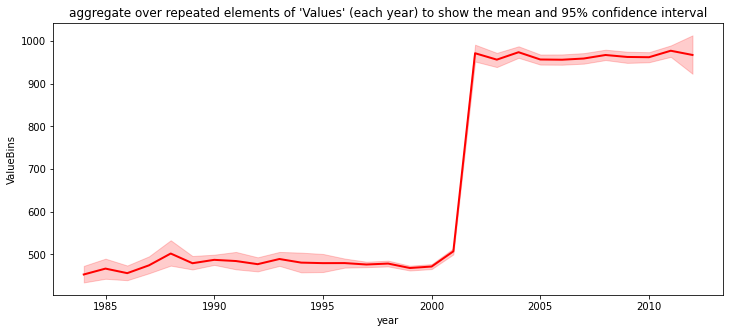

In [ ]:
plt.figure(figsize=(12,5)) 
sns.lineplot(x=df.year,y=df.ValueBins,data=df , color = "red" , linewidth = 2 )
plt.title("aggregate over repeated elements of 'Values' (each year) to show the mean and 95% confidence interval") 
plt.show()

## observation
<p>1) there is sudden rise in average Value from 2001</p>
<p>2) as per wikipedia "The 1984 series' first-round originally ranged from \$100 to \$500 (doubled again from the second pilot/Double jeopardy),and was doubled to \$200 to \$1,000 on November 26, 2001"</p>
<p>3) link "https://en.wikipedia.org/wiki/Jeopardy!" </p>
<p>4) although there are some changes as values are crossed above 1000 but in few quantities but score/Value in game was doubled in 2001 was observed in our dataset as well</p>

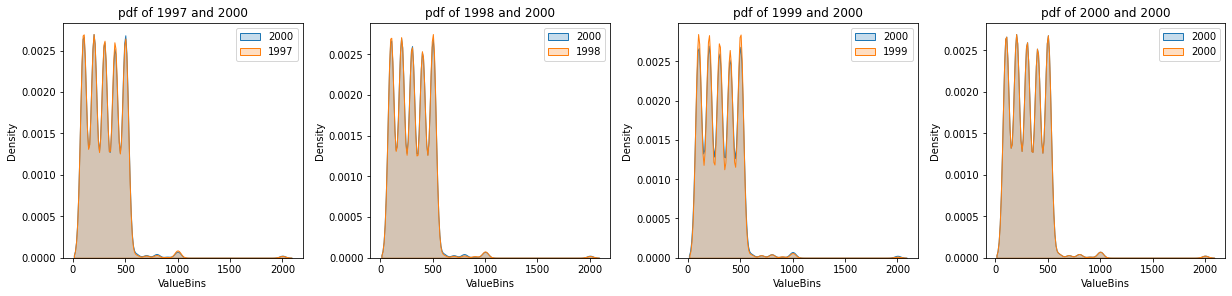

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(17, 4),constrained_layout=True)
year_before_2000=[1997,1998,1999,2000]


for i in range(0,len(year_before_2000)):
  sns.kdeplot(df.loc[(df["year"]==2000) & (df["Round"]=="Jeopardy!"),"ValueBins"], shade=True, ax=ax[i])
  sns.kdeplot(df.loc[(df["year"]==year_before_2000[i]) & (df["Round"]=="Jeopardy!"),"ValueBins"], shade=True, ax=ax[i]) 
  ax[i].set_title("pdf of "+str(year_before_2000[i])+" and 2000")
  ax[i].set_xlabel('ValueBins')
  ax[i].legend(["2000", year_before_2000[i]])



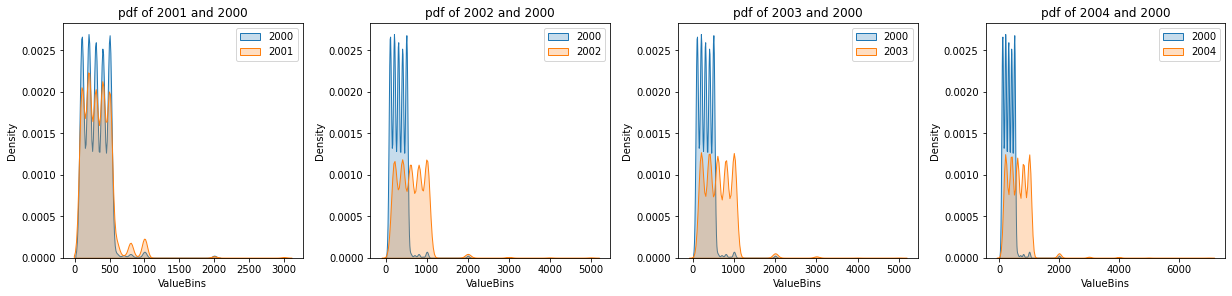

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(17, 4),constrained_layout=True)
year_after_2000=[2001,2002,2003,2004]


for i in range(0,len(year_before_2000)):
  sns.kdeplot(df.loc[(df["year"]==2000) & (df["Round"]=="Jeopardy!"),"ValueBins"], shade=True, ax=ax[i])
  sns.kdeplot(df.loc[(df["year"]==year_after_2000[i]) & (df["Round"]=="Jeopardy!"),"ValueBins"], shade=True, ax=ax[i]) 
  ax[i].set_title("pdf of "+str(year_after_2000[i])+" and 2000")
  ax[i].set_xlabel('ValueBins')
  ax[i].legend(["2000", year_after_2000[i]])


## Observation
1)as we can see from above graphs that distribtuiton is totally different before 2000 and after 2000 hence we can use strategy of "divide and conquor approach" and train different model for above scenarios

# split the data

In [6]:
#divide the data at th year 2000
df_after_2000=df.loc[df["year"]>2000]
df_before_2000=df.loc[df["year"]<=2000]

In [7]:
df_after_2000=df_after_2000.reset_index()
df_after_2000=df_before_2000.reset_index()

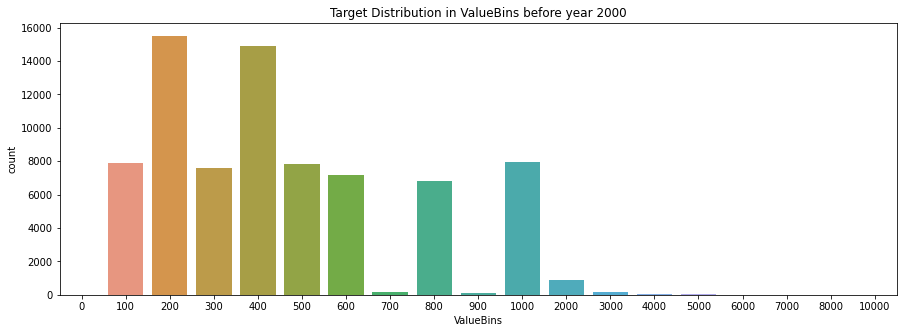

In [ ]:
plt.figure(figsize=(15, 5))
sns.countplot(x=df_before_2000['ValueBins'])

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title('Target Distribution in ValueBins before year 2000')

plt.show()

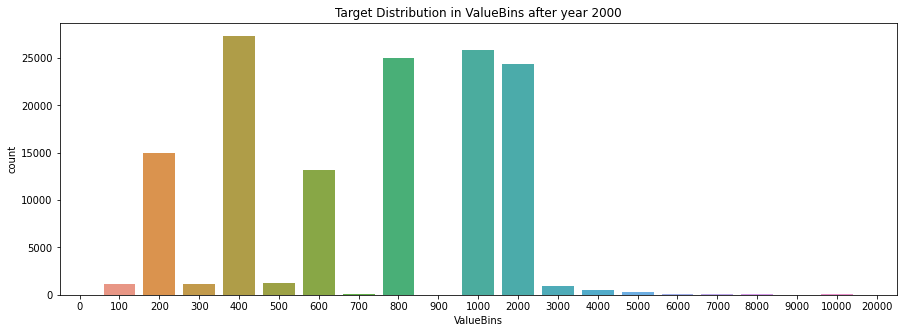

In [ ]:
plt.figure(figsize=(15, 5))
sns.countplot(x=df_after_2000['ValueBins'])

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.title('Target Distribution in ValueBins after year 2000')

plt.show()

#lets start with before 2000

In [8]:
df_before_2000.sort_values(by=['year'], ascending=True,inplace=True) #sort according to year

In [9]:
y=df_before_2000['ValueBins']

x=df_before_2000[:]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle=False)
#split the data with respect to year in ascending order hence shuffle=False 

In [11]:
print(X_train.shape)
print(X_test.shape)

(53821, 5)
(23067, 5)


In [12]:
X_train=X_train.reset_index() 
X_test=X_test.reset_index()

In [13]:
X_train.drop(["index"],inplace=True,axis=1)
X_test.drop(["index"],inplace=True,axis=1)

In [14]:
Mean_encoded_category = X_train.groupby(['Round','processed_Category'])['ValueBins'].mean().to_dict() #encoding the category variable with mean of ValueBins w.r.t to year,Round and cateogory


In [15]:
for i in Mean_encoded_category.keys():
  X_train.loc[(X_train["Round"]==i[0]) & (X_train["processed_Category"]==i[1]),"processed_Category"]=str(Mean_encoded_category[i])
  X_test.loc[(X_test["Round"]==i[0]) & (X_test["processed_Category"]==i[1]),"processed_Category"]=str(Mean_encoded_category[i])

In [16]:
for i in X_test["processed_Category"]:
  if i.replace('.','').isdigit()==False:
    X_test.loc[X_test["processed_Category"]==i,"processed_Category"]='0'

In [17]:
X_train["processed_Category"]=X_train["processed_Category"].astype(float)
X_test["processed_Category"]=X_test["processed_Category"].astype(float)

In [18]:
X_train.drop(["year","ValueBins"],inplace=True,axis=1)
X_test.drop(["year","ValueBins"],inplace=True,axis=1) #remvoing year as as from data the average was flat before and after 2000 hence not necessary

In [ ]:
X_train.head()

,Round,processed_Category,processed_question
0,0,257.142857,Long associated Lebanon tree flag
1,1,600.000000,famous marriages music wed Ava Gardner Lana Tu...
2,1,650.000000,inmates guards killed uprising NY prison
3,1,626.315789,species Hawaiian honeycreeper list
4,1,688.888889,large crowd bees move


## creating vectors for question usinf tf-idf weighted Word2vec

### for vectors for train

In [ ]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train["processed_question"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
tokenized_ques_train = [word_tokenize(X_train["processed_question"][i]) for i in range(0,len(X_train["processed_question"]))]

In [ ]:
tfidf_feat = model.get_feature_names()

tfidf_ques_vectors_train = []; # the tfidf-w2v for each sentence/question is stored in this list
row=0;
for sent in tqdm(tokenized_ques_train): # for each question/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/question
    for word in sent: # for each word in a question/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_ques_vectors_train.append(sent_vec)
    row=row+1

100%|██████████| 53821/53821 [26:37<00:00, 33.68it/s]


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/wysa/tfidf_ques_vectors_train_before_2000.pickle', 'wb') as f:
    pickle.dump(tfidf_ques_vectors_train, f)

In [ ]:
tfidf_ques_vectors_train= pd.read_pickle(r'/content/drive/MyDrive/Colab Notebooks/wysa/tfidf_ques_vectors_train_before_2000.pickle')

In [ ]:
#add the 300 dim vector coulmns to dataframe
cols = ['{}_{}'.format("question", n) for n in range(1, 300 + 1)]
encoded_df = pd.DataFrame(tfidf_ques_vectors_train, columns=cols)
encoded_df.index = X_train.index

In [ ]:
X_train=pd.concat((X_train,encoded_df), axis=1)

In [ ]:
X_train.drop(["processed_question"],axis=1,inplace=True)

### create vectors for test

In [ ]:
tf_idf_matrix = model.transform(X_test["processed_question"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
tokenized_ques_test = [word_tokenize(X_test["processed_question"][i]) for i in range(0,len(X_test["processed_question"]))]

In [ ]:
tfidf_feat = model.get_feature_names()

tfidf_ques_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(tokenized_ques_test): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_ques_vectors_test.append(sent_vec)
    row=row+1

100%|██████████| 23067/23067 [10:49<00:00, 35.54it/s]


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/wysa/tfidf_ques_vectors_test_before_2000.pickle', 'wb') as f:
    pickle.dump(tfidf_ques_vectors_test, f)

In [ ]:
tfidf_ques_vectors_test= pd.read_pickle(r'/content/drive/MyDrive/Colab Notebooks/wysa/tfidf_ques_vectors_test_before_2000.pickle')

In [ ]:
cols = ['{}_{}'.format("question", n) for n in range(1, 300 + 1)]
encoded_df = pd.DataFrame(tfidf_ques_vectors_test, columns=cols)
encoded_df.index = X_test.index

In [ ]:
X_test=pd.concat((X_test,encoded_df), axis=1)

In [ ]:
X_test.drop(["processed_question"],axis=1,inplace=True)

    

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled_train=scaler.fit_transform(X_train)
X_scaled_test=scaler.transform(X_test)
#scaled the data since category was relatively higher then all other columns

## ML MODEL

## Note
<p>1) tried simple logistic regression model and random forest model without hyperparmater tuning just to check wether its over fitting or underfitting </p>


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [ ]:

lr = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=100,penalty='l1')
lr.fit(X_scaled_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='multinomial', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = lr.predict(X_scaled_train)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
         100       0.26      0.38      0.31      5503
         200       0.25      0.30      0.27     10828
         300       0.26      0.23      0.24      5287
         400       0.25      0.18      0.21     10416
         500       0.27      0.31      0.29      5391
         600       0.24      0.17      0.20      5036
         700       1.00      0.01      0.02        95
         800       0.26      0.15      0.19      4764
         900       0.67      0.03      0.06        59
        1000       0.26      0.36      0.30      5577
        2000       0.14      0.02      0.04       650
        3000       0.60      0.05      0.09       130
        4000       0.53      0.15      0.24        53
        5000       0.75      0.16      0.26        19
        6000       1.00      0.20      0.33         5
        7000       0.00      0.00      0.00         1
        8000       0.00    

In [ ]:
y_pred = lr.predict(X_scaled_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         100       0.22      0.43      0.29      2352
         200       0.22      0.28      0.24      4652
         300       0.20      0.22      0.21      2266
         400       0.19      0.14      0.17      4476
         500       0.23      0.18      0.20      2401
         600       0.17      0.12      0.14      2128
         700       0.00      0.00      0.00        62
         800       0.17      0.07      0.10      2060
         900       0.00      0.00      0.00        31
        1000       0.22      0.22      0.22      2357
        2000       0.03      0.00      0.01       242
        3000       0.00      0.00      0.00        21
        4000       0.00      0.00      0.00        13
        5000       0.00      0.00      0.00         5
        6000       0.00      0.00      0.00         1

    accuracy                           0.21     23067
   macro avg       0.11      0.11      0.10     23067
weighted avg       0.20   

## observation
<p>comparing both train and test alteast model is not overfitting but its underfitting</p>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, random_state=0,class_weight="balanced")
clf.fit(X_scaled_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = clf.predict(X_scaled_train)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
         100       0.97      0.98      0.97      5503
         200       1.00      0.97      0.99     10828
         300       0.94      0.99      0.96      5287
         400       1.00      0.97      0.99     10416
         500       0.97      0.98      0.97      5391
         600       0.97      0.99      0.98      5036
         700       0.79      1.00      0.88        95
         800       0.98      0.99      0.98      4764
         900       0.88      1.00      0.94        59
        1000       0.99      0.99      0.99      5577
        2000       0.92      1.00      0.96       650
        3000       0.96      1.00      0.98       130
        4000       0.93      1.00      0.96        53
        5000       1.00      1.00      1.00        19
        6000       1.00      1.00      1.00         5
        7000       1.00      1.00      1.00         1
        8000       1.00    

In [ ]:
y_pred = clf.predict(X_scaled_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         100       0.21      0.25      0.23      2352
         200       0.20      0.33      0.25      4652
         300       0.18      0.16      0.17      2266
         400       0.19      0.23      0.21      4476
         500       0.22      0.17      0.19      2401
         600       0.19      0.08      0.11      2128
         700       0.00      0.00      0.00        62
         800       0.18      0.06      0.09      2060
         900       0.00      0.00      0.00        31
        1000       0.22      0.17      0.19      2357
        2000       0.01      0.01      0.01       242
        3000       0.00      0.00      0.00        21
        4000       0.00      0.00      0.00        13
        5000       0.00      0.00      0.00         5
        6000       0.00      0.00      0.00         1

    accuracy                           0.20     23067
   macro avg       0.11      0.10      0.10     23067
weighted avg       0.20   

In [ ]:

import xgboost as xgb
xgb_model = xgb.XGBClassifier()
#parameters = { 'max_depth': [6,8,10,15],'n_estimators': [8,10,15,20,25,50]}
#clf = GridSearchCV(xgb_model, parameters, cv=4, scoring='average_precision',return_train_score=True)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = xgb_model.predict(X_train)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
         100       0.33      0.48      0.39      5503
         200       0.31      0.50      0.39     10828
         300       0.41      0.23      0.30      5287
         400       0.40      0.20      0.27     10416
         500       0.30      0.44      0.36      5391
         600       0.50      0.14      0.21      5036
         700       1.00      0.01      0.02        95
         800       0.53      0.11      0.18      4764
         900       1.00      0.14      0.24        59
        1000       0.30      0.54      0.38      5577
        2000       1.00      0.01      0.02       650
        3000       0.89      0.06      0.12       130
        4000       1.00      0.26      0.42        53
        5000       1.00      0.47      0.64        19
        6000       1.00      0.80      0.89         5
        7000       0.00      0.00      0.00         1
        8000       0.00    

In [ ]:
y_pred = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         100       0.21      0.43      0.29      2352
         200       0.21      0.44      0.28      4652
         300       0.19      0.10      0.13      2266
         400       0.18      0.06      0.09      4476
         500       0.23      0.23      0.23      2401
         600       0.20      0.04      0.06      2128
         700       0.00      0.00      0.00        62
         800       0.20      0.02      0.04      2060
         900       0.00      0.00      0.00        31
        1000       0.22      0.26      0.24      2357
        2000       0.00      0.00      0.00       242
        3000       0.00      0.00      0.00        21
        4000       0.00      0.00      0.00        13
        5000       0.00      0.00      0.00         5
        6000       0.00      0.00      0.00         1

    accuracy                           0.21     23067
   macro avg       0.11      0.11      0.09     23067
weighted avg       0.20   

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
y_pred = gnb.predict(X_train)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
         100       0.23      0.57      0.33      5503
         200       0.26      0.07      0.11     10828
         300       0.23      0.32      0.27      5287
         400       0.30      0.01      0.02     10416
         500       0.24      0.22      0.23      5391
         600       0.22      0.19      0.21      5036
         700       0.02      0.13      0.04        95
         800       0.20      0.31      0.25      4764
         900       0.03      0.34      0.05        59
        1000       0.25      0.19      0.22      5577
        2000       0.07      0.08      0.08       650
        3000       0.02      0.38      0.05       130
        4000       0.01      0.77      0.02        53
        5000       0.12      0.89      0.21        19
        6000       0.31      1.00      0.48         5
        7000       1.00      1.00      1.00         1
        8000       1.00    

In [ ]:
y_pred = gnb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         100       0.22      0.38      0.28      2352
         200       0.22      0.19      0.21      4652
         300       0.20      0.23      0.22      2266
         400       0.19      0.07      0.11      4476
         500       0.23      0.16      0.19      2401
         600       0.18      0.10      0.13      2128
         700       0.00      0.02      0.00        62
         800       0.18      0.18      0.18      2060
         900       0.00      0.00      0.00        31
        1000       0.22      0.11      0.14      2357
        2000       0.02      0.02      0.02       242
        3000       0.00      0.00      0.00        21
        4000       0.00      0.46      0.00        13
        5000       0.00      0.00      0.00         5
        6000       0.00      0.00      0.00         1

    accuracy                           0.17     23067
   macro avg       0.11      0.13      0.10     23067
weighted avg       0.20   

## observation
<p>1) its overfitting </p>

## deep learning models

In [19]:
!pip install transformers



     |████████████████████████████████| 1.9MB 5.4MB/s 
     |████████████████████████████████| 3.2MB 19.9MB/s 
     |████████████████████████████████| 890kB 37.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=dc197b23a028bca697bc1f8eba94dcdfdcc4a8eaccd79f2725b2bc38a3669d99
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [20]:
from tensorflow.keras.layers import Dense, Input
import tensorflow as tf
from transformers import  DistilBertConfig,TFDistilBertModel
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dropout, GlobalAveragePooling1D


In [21]:
from keras.layers import Input,LSTM, Dense,Dropout
from keras.models import Model
#from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import roc_auc_score
from scipy.sparse import hstack
from keras.preprocessing.sequence import pad_sequences
#from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import concatenate

In [ ]:

from transformers import DistilBertTokenizer

distil_bert = 'distilbert-base-uncased' # Name of the pretrained models

#DistilBERT 
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert)


In [23]:


config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config = config)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [24]:
round=X_train["Round"].values

In [25]:
round

array([0, 1, 1, ..., 1, 1, 1])

In [26]:
round=round.reshape(-1,1)

In [27]:
round.shape

(53821, 1)

In [28]:
round_test=X_test["Round"].values
round_test=round_test.reshape(-1,1)

In [29]:
category=X_train["processed_Category"].values
category=category.reshape(-1,1)

In [ ]:
y_train

69103     200
8435      600
8436      600
8437      600
8438      600
         ... 
164712    400
164710    400
164709    400
164708    400
164707    400
Name: ValueBins, Length: 53821, dtype: int64

In [30]:
y_train=y_train.values

In [31]:
y_train

array([200, 600, 600, ..., 400, 400, 400])

In [32]:
y_test=y_test.values

In [33]:
total_classes = [0,100,200,300,400,500,600,700,800,900,1000,2000,3000,4000,5000,6000,7000,8000,10000]

### map each class to an integer
mapping = {}
for x in range(len(total_classes)):
  mapping[total_classes[x]] = x

for x in range(len(y_train)):
  y_train[x] = mapping[y_train[x]]

#converting y_train into categorical variable since we know that to_categorical can only be used if the class lie in the range of number mentioned in num_classes so built custom  one hot encoding where it maps it
# to integer


In [34]:
for x in range(len(y_test)):
  y_test[x] = mapping[y_test[x]]

#converting y_test into categorical variable


In [35]:
from tensorflow.keras.utils import to_categorical
y_new_train = to_categorical(y_train)
y_new_test = to_categorical(y_test)
#now we can apply to_categroical 

In [ ]:
y_pred

array([[0.05280853, 0.05349982, 0.04768982, ..., 0.04608155, 0.05689994,
        0.06176927],
       [0.05280852, 0.05349982, 0.04768982, ..., 0.04608155, 0.05689992,
        0.06176926],
       [0.05280854, 0.05349982, 0.04768982, ..., 0.04608155, 0.05689994,
        0.06176927],
       ...,
       [0.05280853, 0.05349982, 0.04768981, ..., 0.04608154, 0.05689994,
        0.06176927],
       [0.05280853, 0.05349983, 0.04768982, ..., 0.04608154, 0.05689993,
        0.06176926],
       [0.05280852, 0.05349982, 0.04768982, ..., 0.04608154, 0.05689992,
        0.06176926]], dtype=float32)

In [ ]:
print(model.config)

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.3.3",
  "vocab_size": 30522
}



### tokenization

In [38]:
tokenized_train = X_train["processed_question"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [39]:
tokenized_test = X_test["processed_question"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

### padding

In [40]:
max_len = 64


padded_train = np.array([i + [0]*(max_len-len(i)) for i in tokenized_train.values])

In [41]:



padded_test = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])

In [42]:
np.array(padded_train).shape

(53821, 64)

In [43]:
padded_test.shape

(23067, 64)

### masking

In [44]:
attention_mask_train = np.where(padded_train != 0, 1, 0)
attention_mask_train.shape

(53821, 64)

In [45]:
attention_mask_test = np.where(padded_test != 0, 1, 0)
attention_mask_test.shape

(23067, 64)

In [46]:
input_ids_train = tf.convert_to_tensor(padded_train)  
attention_mask_train = tf.convert_to_tensor(attention_mask_train)

In [47]:
input_ids_test = tf.convert_to_tensor(padded_test)  
attention_mask_test = tf.convert_to_tensor(attention_mask_test)

# model

In [52]:
#here i have used function api technique in keras instead of sequential model 
# inputs are input1=input_ids_in, input2=input_masks_in input3=round_input 
#model design is to use bert for embedding sentences and round feature to combine and train an single deep learning model
#.  input id and mask (inputs)
#      |
#.    bert
#      |
# cls_token [768 dim]              round [1 dim] (input)   category (input)
#      |                               |                       |
#.  dense and flatten                dense                   dense
#.     |                               |                       |
#       _______________________________ _______________________
#                        |
#               dense and droupout
#                        |
#                     softmax

input_ids_in = Input(shape=(64,), name='input_token', dtype='int32')
input_masks_in = Input(shape=(64,), name='masked_token', dtype='int32') 
round_input=Input(shape=(round.shape[1],),name='round_input',sparse=False)
category_input=Input(shape=(category.shape[1],),name='category_input',sparse=False)

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
cls_token = embedding_layer[:,0,:]

x1 = tf.keras.layers.Dense(500, activation='relu')(cls_token)
x1 = tf.keras.layers.Dropout(0.2)(x1)
x1 = tf.keras.layers.Dense(400, activation='relu')(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.Dense(300, activation='relu')(x1)
x1 = Flatten()(x1)

x2= Dense(2, activation='relu')(round_input)

x3=Dense(128, activation='relu')(category_input)


concat = concatenate([x1,x2,x3])

x = Dense(300,activation='relu')(concat)
x = Dropout(0.7)(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu')(x)
output = Dense(19, activation = 'softmax')(x)


model = Model(inputs=[input_ids_in, input_masks_in,round_input,category_input], outputs = output)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0006,decay = 1e-4),metrics='acc')

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 64)]         0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 768)          0           tf_distil_bert_model[2][0] 

In [53]:
model.fit([input_ids_train,attention_mask_train,round,category], y_new_train, epochs=6,batch_size=64,verbose=1,
          validation_split = 0.1)

Epoch 1/6
757/757 [==============================] - 197s 247ms/step - loss: 6.5337 - acc: 0.1583 - val_loss: 2.1637 - val_acc: 0.2008
Epoch 2/6
757/757 [==============================] - 185s 244ms/step - loss: 2.1457 - acc: 0.1976 - val_loss: 2.1083 - val_acc: 0.2008
Epoch 3/6
757/757 [==============================] - 185s 244ms/step - loss: 2.1126 - acc: 0.1985 - val_loss: 2.1044 - val_acc: 0.2008
Epoch 4/6
757/757 [==============================] - 184s 243ms/step - loss: 2.1088 - acc: 0.1993 - val_loss: 2.1038 - val_acc: 0.2008
Epoch 5/6
757/757 [==============================] - 184s 243ms/step - loss: 2.1095 - acc: 0.2008 - val_loss: 2.1028 - val_acc: 0.2008
Epoch 6/6
757/757 [==============================] - 184s 243ms/step - loss: 2.1042 - acc: 0.1979 - val_loss: 2.1024 - val_acc: 0.2008


## observation
1)its underfitting 

## Note: same process has to be followed for after 2000 as well


